# Data

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV # important!!!!!!!!!!!!!!!!!!!!!!!!!!!!
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

ModuleNotFoundError: No module named 'xgboost'

In [2]:
# df = pd.read_pickle('./drive/Msc_FYP/data/data_100.pickle')
# items = pd.read_pickle('./drive/Msc_FYP/data/fdump_100.pickle')
df = pd.read_pickle('data_100.pickle')
items = pd.read_pickle('fdump_100.pickle')

In [3]:
df = df.query('defined_target_vb100_vf2_volatility_VWAP_200 == 1')

In [4]:
for c in df.columns:
     if c.startswith('sample_weights'):
        print(c)

sample_weights_vb50_vf2_volatility_VWAP_200
sample_weights_vb50_vf3_volatility_VWAP_200
sample_weights_vb100_vf2_volatility_VWAP_200
sample_weights_vb100_vf3_volatility_VWAP_200
sample_weights_vb200_vf2_volatility_VWAP_200
sample_weights_vb200_vf3_volatility_VWAP_200
sample_weights_not0_vb50_vf2_volatility_VWAP_200
sample_weights_not0_vb50_vf3_volatility_VWAP_200
sample_weights_not0_vb100_vf2_volatility_VWAP_200
sample_weights_not0_vb100_vf3_volatility_VWAP_200
sample_weights_not0_vb200_vf2_volatility_VWAP_200
sample_weights_not0_vb200_vf3_volatility_VWAP_200


In [69]:
df.iloc[:2910].tail(10)

,VolatilityDelta_EWMA25R_VWAP,ADX50R,EWMA200R_FD_VWAP,LogRet_100R_High,EWMA25R_VWAP,CrossBarVol_Close_200R,EWMA5R_VWAP,EWMA200R_NormCORange,sigma_EWMA100R_VWAP,EWMA100R_NormCORange,...,target_not0_vb50_vf3_volatility_VWAP_200,sample_weights_not0_vb50_vf3_volatility_VWAP_200,target_not0_vb100_vf2_volatility_VWAP_200,sample_weights_not0_vb100_vf2_volatility_VWAP_200,target_not0_vb100_vf3_volatility_VWAP_200,sample_weights_not0_vb100_vf3_volatility_VWAP_200,target_not0_vb200_vf2_volatility_VWAP_200,sample_weights_not0_vb200_vf2_volatility_VWAP_200,target_not0_vb200_vf3_volatility_VWAP_200,sample_weights_not0_vb200_vf3_volatility_VWAP_200
bucket_end,,,,,,,,,,,,,,,,,,,,,
2017-12-29 10:36:50,-0.107617,6.303047,5.052981,-0.000151,66.414312,0.091280,66.435400,1.262971e-06,0.148101,-5.946845e-06,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2017-12-29 10:47:40,0.784501,5.911292,5.053226,0.001655,66.419150,0.089936,66.439273,3.802463e-06,0.144806,-5.422318e-07,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.387627,0.0,0.000000
2017-12-29 10:53:50,0.252658,5.924808,5.053229,0.000903,66.421485,0.087468,66.439840,6.530785e-07,0.143341,-6.657482e-06,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.395649,0.0,0.000000
2017-12-29 11:12:50,0.414849,6.613188,5.053994,0.001053,66.434753,0.079647,66.468916,2.632654e-06,0.140071,-2.370879e-06,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.346820,0.0,0.000000
2017-12-29 11:55:00,-0.268491,7.281596,5.051820,0.000301,66.412115,0.046398,66.379737,-2.699128e-06,0.126296,-1.032855e-05,...,0.0,0.000000,1.0,0.234370,1.0,0.341283,1.0,0.162297,1.0,0.253608
2018-01-02 08:37:00,-0.159530,11.151385,5.106216,-0.004472,66.931897,0.130014,66.907596,-1.188173e-07,0.183602,-3.072136e-06,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.442330,0.0,0.000000
2018-01-02 11:23:20,-1.054159,14.661963,5.076132,-0.001950,66.683976,0.096562,66.606429,-4.196931e-06,0.161936,-7.009800e-06,...,1.0,0.811979,1.0,0.748962,1.0,0.672260,1.0,0.888203,1.0,0.516728
2018-01-02 11:30:05,-0.058962,14.634737,5.075749,-0.000899,66.680194,0.096480,66.632442,-1.594607e-08,0.162032,1.344209e-06,...,0.0,0.000000,1.0,0.748309,1.0,0.678597,1.0,0.875630,1.0,0.530507
2018-01-02 11:33:20,0.279077,14.534528,5.075598,-0.000300,66.681633,0.095043,66.659150,5.097326e-07,0.161131,2.370583e-06,...,0.0,0.000000,1.0,0.966784,0.0,0.000000,1.0,1.155202,0.0,0.000000


limit_output extension: Maximum message size of 10000 exceeded with 12987 characters

In [4]:
df.shape

(3448, 971)

In [5]:
feats_dict3 = {'gram':[c for c in df.columns if c.startswith('gram')],
              'pos':[c for c in df.columns if c.startswith('pos')],
              'title_tfidf':[c for c in df.columns if c.startswith('title_tfidf')],
              'source_bow':[c for c in df.columns if c.startswith('source_bow')],
              'Pre_Doc2Vec': [c for c in df.columns if c.startswith('Pre_Doc2Vec')],
              'pol_sub':[c for c in df.columns if c.startswith('polarity') | c.startswith('subje')],
              'tfidf':[c for c in df.columns if c.startswith('tfidf')]}

gram = feats_dict3['gram']
pos = feats_dict3['pos']
title = feats_dict3['title_tfidf']
source = feats_dict3['source_bow']
Doc2Vec = feats_dict3['Pre_Doc2Vec']
pol_sub = feats_dict3['pol_sub']
tfidf = feats_dict3['tfidf']

In [6]:
df.shape #(5193-3500=1693)

#[:3600] [3600:4630][4630:]

(3448, 971)

#Only nlp

## training functions


In [7]:
#-------------------------------------------------------------
def get_data(data, feats_col, target_col):

    X = data[feats_col].apply(np.float32)
   
    X = X.values
    targets = ['target_{}'.format(target_col)]
    targets_dataframe = df[targets]
    targets_dataframe[targets] = np.where(targets_dataframe[targets]!=-1,targets_dataframe[targets],float(2))
    y = targets_dataframe.values
    
    c, r = y.shape
    y = y.reshape(c,)
    
    
    return X, y
  

#-------------------------------------------------------------
# -------------------------------------------------------------
def cv_generator(n_cv):
    
    N = 2758 #4089 [0:3600] [3600:4630] [4630:]
    
    n_train = int(np.floor(N/(1+0.3*n_cv)))
    n_test = int(np.floor(0.3*n_train))
    
    for cv_idx in range(n_cv):
        
        train_idx = [i for i in range(cv_idx*n_test, cv_idx*n_test +n_train)] 
        test_idx = [i for i in range(cv_idx*n_test +n_train, (cv_idx+1)*n_test +n_train)] 
        
        yield (train_idx, test_idx)
        
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
from scipy import interp
def AUC(y_true,y_probas):
    
#     print(y_probas)
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)


    classes = np.unique(y_true)
    probas = y_probas

    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true, probas[:, i],
                                      pos_label=classes[i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    average_score = (roc_auc[1]+roc_auc[2])/2
    return average_score
  
  
  
  
  
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
from scipy import interp

title_fontsize="small"
text_fontsize="small"
curves=('micro', 'macro', 'each_class')
cmap='nipy_spectral'


def plot_AUC(true_y,predict,title):


    plt.figure()
    y_true = true_y
    y_probas = predict
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)

    if 'micro' not in curves and 'macro' not in curves and \
            'each_class' not in curves:
        raise ValueError('Invalid argument for curves as it '
                         'only takes "micro", "macro", or "each_class"')

    classes = np.unique(y_true)
    probas = y_probas

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true, probas[:, i],
                                      pos_label=classes[i])
        roc_auc[i] = auc(fpr[i], tpr[i])
       

    # Compute micro-average ROC curve and ROC area
    micro_key = 'micro'
    i = 0
    while micro_key in fpr:
        i += 1
        micro_key += str(i)

    y_true = label_binarize(y_true, classes=classes)
    if len(classes) == 2:
        y_true = np.hstack((1 - y_true, y_true))

    fpr[micro_key], tpr[micro_key], _ = roc_curve(y_true.ravel(),
                                                  probas.ravel())
    roc_auc[micro_key] = auc(fpr[micro_key], tpr[micro_key])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[x] for x in range(len(classes))]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= len(classes)

    macro_key = 'macro'
    i = 0
    while macro_key in fpr:
        i += 1
        macro_key += str(i)
    fpr[macro_key] = all_fpr
    tpr[macro_key] = mean_tpr
    roc_auc[macro_key] = auc(fpr[macro_key], tpr[macro_key])
   

    title = title
    plt.title(title, fontsize=title_fontsize)

#         if 'each_class' in curves:
    for i in range(len(classes)):
        color = plt.cm.get_cmap(cmap)(float(i) / len(classes))
        plt.plot(fpr[i], tpr[i], lw=2, color=color,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(classes[i], roc_auc[i]))

#         if 'micro' in curves:
    plt.plot(fpr[micro_key], tpr[micro_key],
            label='micro-average ROC curve '
                  '(area = {0:0.2f})'.format(roc_auc[micro_key]),
            color='deeppink', linestyle=':', linewidth=4)

#         if 'macro' in curves:
    plt.plot(fpr[macro_key], tpr[macro_key],
            label='macro-average ROC curve '
                  '(area = {0:0.2f})'.format(roc_auc[macro_key]),
            color='navy', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=text_fontsize)
    plt.ylabel('True Positive Rate', fontsize=text_fontsize)
    plt.tick_params(labelsize=text_fontsize)
    plt.legend(loc='lower right', fontsize=text_fontsize)
    plt.show()
    


## single nlp

In [13]:
# output_dict3={}

# feats_dict3 = {'gram':[c for c in df.columns if c.startswith('gram')],
#               'pos':[c for c in df.columns if c.startswith('pos')],
#               'title_tfidf':[c for c in df.columns if c.startswith('title_tfidf')],
#               'source_bow':[c for c in df.columns if c.startswith('source_bow')],
#               'Pre_Doc2Vec': [c for c in df.columns if c.startswith('Pre_Doc2Vec')],
#               'pol_sub':[c for c in df.columns if c.startswith('polarity') | c.startswith('subje')],
#               'tfidf':[c for c in df.columns if c.startswith('tfidf')]}

# AUC_score = make_scorer(AUC, greater_is_better=True, needs_proba = True)
# scoring = {'AUC': AUC_score}


# target_cols = 'vb100_vf2_volatility_VWAP_200'
# i = 0
# for feats_key, feats_col in feats_dict3.items():                

#     i+=1

#     X, y = get_data(df, feats_col, target_cols)

#     #XGBOOST()
#     weights = df['sample_weights_vb100_vf2_volatility_VWAP_200']
#     cv = cv_generator(2)
#     fit_params={"early_stopping_rounds":5, 
#                 "eval_metric" : "mlogloss", 
#                 "eval_set" : [(X[2758:], y[2758:])],
#                 "verbose":5}


#     gs = GridSearchCV(XGBClassifier(objective= 'multi:softprob'),
#                       param_grid={
#                                   'learning_rate':[0.3],
#                                  },
#                       scoring= scoring,
#                       fit_params = fit_params,
#                       cv = cv,
#                       n_jobs=10,
#                       verbose=1,
#                       refit= 'AUC') #

    
#     gs.fit(X, y)
#     output_dict3['model_{}'.format(i)] = {'target':target_cols, 'feats':feats_key, 'GridObject':gs}

     
        
        

### result_1

In [16]:
output_3 = pd.DataFrame.from_dict(output_dict3, orient='index')
# train['word_count'] = train['content'].apply(lambda x: len(str(x).split(" ")))
output_3['para']=output_3['GridObject'].apply(lambda x: x.best_params_ )
output_3['score']=output_3['GridObject'].apply(lambda x: x.best_score_ )

output_3


,target,feats,GridObject,para,score
model_1,vb100_vf2_volatility_VWAP_200,gram,GridSearchCV(cv=<generator object cv_generator...,{'learning_rate': 0.3},0.500024
model_2,vb100_vf2_volatility_VWAP_200,pos,GridSearchCV(cv=<generator object cv_generator...,{'learning_rate': 0.3},0.483609
model_3,vb100_vf2_volatility_VWAP_200,title_tfidf,GridSearchCV(cv=<generator object cv_generator...,{'learning_rate': 0.3},0.511855
model_4,vb100_vf2_volatility_VWAP_200,source_bow,GridSearchCV(cv=<generator object cv_generator...,{'learning_rate': 0.3},0.512144
model_5,vb100_vf2_volatility_VWAP_200,Pre_Doc2Vec,GridSearchCV(cv=<generator object cv_generator...,{'learning_rate': 0.3},0.508437
model_6,vb100_vf2_volatility_VWAP_200,pol_sub,GridSearchCV(cv=<generator object cv_generator...,{'learning_rate': 0.3},0.521126
model_7,vb100_vf2_volatility_VWAP_200,tfidf,GridSearchCV(cv=<generator object cv_generator...,{'learning_rate': 0.3},0.506042


## hyper-parameter, many nlp

In [17]:
#----------------------------------------
def precision(y_true,y_probas):
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)
    classes = np.unique(y_true)
    probas = y_probas
    y_true = label_binarize(y_true, classes=classes)
    
    average_precision = {}
    for i in range(len(classes)):
        average_precision[i] = average_precision_score(y_true[:, i], probas[:, i])
        
    ave_precision = (average_precision[1]+average_precision[2])/2

    return ave_precision
    
def recall(y_true,y_probas):
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)
    classes = np.unique(y_true)
    probas = y_probas
    y_true = label_binarize(y_true, classes=classes)
    
    recall_dict = {}
    for i in range(len(classes)):
        recall_dict[i] = recall_score(y_true[:, i], probas[:, i].round())
        
    ave_recall = (recall_dict[1]+recall_dict[2])/2

    return ave_recall


def accuracy(y_true,y_probas):
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)
    classes = np.unique(y_true)
    probas = y_probas
    y_true = label_binarize(y_true, classes=classes)
    
    acc = {}
    for i in range(len(classes)):
        acc[i] = accuracy_score(y_true[:, i], probas[:, i].round())
        
    ave_acc = (acc[1]+acc[2])/2
    
    return ave_acc

In [22]:
# pol_sub+source+title+Doc2Vec+tfidf+gram+pos
feats_com = [pol_sub,pol_sub+source,pol_sub+source+title,
            pol_sub+source+title+Doc2Vec+tfidf,
            pol_sub+source+title+Doc2Vec+tfidf+gram+pos]

output_dict3={}

AUC_score = make_scorer(AUC, greater_is_better=True, needs_proba = True)
_precision_score = make_scorer(precision, greater_is_better=True, needs_proba = True)
_recall_score = make_scorer(recall, greater_is_better=True, needs_proba = True)
_accuracy_score = make_scorer(accuracy, greater_is_better=True, needs_proba = True)

scoring = {'AUC': AUC_score,'precision':_precision_score,'recall':_recall_score,'accuracy':_accuracy_score}

learning_rate = [[3.0],[2.8],[0.3],[2.6],[3.2]]
n_estimators = [[400],[800],[100],[600],[400]]
max_depth = [[5],[2],[5],[3],[4]]
min_child_weight = [[1],[1],[4],[3],[2]]
gamma = [[0.2],[0],[0],[0],[0]]
subsample = [[0.8],[1],[1],[0.9],[0.9]]
colsample_bytree = [[0.6],[1],[1],[0.7],[0.6]]
reg_alpha = [[0],[0],[0.01],[0],[0]]
             

target_cols = 'vb100_vf2_volatility_VWAP_200'
for i in range(5):
    print(i)
    
    feature = feats_com[i]
    X, y = get_data(df, feature, target_cols)
    cv = cv_generator(1)

    xgb = XGBClassifier(
                         objective= 'multi:softprob',
                        )


    gs = GridSearchCV(xgb,
                      param_grid={
                                  'learning_rate':learning_rate[i],
                                  'n_estimators':n_estimators[i],
                                  'max_depth':max_depth[i],
                                  'min_child_weight':min_child_weight[i],
                                  'gamma':gamma[i],
                                  'subsample':subsample[i],
                                  'colsample_bytree':colsample_bytree[i],
                                  'reg_alpha':reg_alpha[i]
                                 },
                      scoring= scoring,
                      cv = cv,
                      n_jobs=15,
                      verbose=1,
                      refit='AUC')


    gs.fit(X[:2758], y[:2758])
    output_dict3['model_{}'.format(i+1)] = {'target':target_cols,'GridObject':gs}

        
        

0
Fitting 1 folds for each of 1 candidates, totalling 1 fits


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

1
Fitting 1 folds for each of 1 candidates, totalling 1 fits


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

2
Fitting 1 folds for each of 1 candidates, totalling 1 fits


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

3
Fitting 1 folds for each of 1 candidates, totalling 1 fits


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

4
Fitting 1 folds for each of 1 candidates, totalling 1 fits


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

### results

In [23]:
output_3 = pd.DataFrame.from_dict(output_dict3, orient='index')
# train['word_count'] = train['content'].apply(lambda x: len(str(x).split(" ")))
output_3['para']=output_3['GridObject'].apply(lambda x: x.best_params_ )
output_3['score']=output_3['GridObject'].apply(lambda x: x.best_score_ )
output_3['Accuracy']=output_3['GridObject'].apply(lambda x: x.cv_results_['mean_test_accuracy'][0])
output_3['Recall']=output_3['GridObject'].apply(lambda x: x.cv_results_['mean_test_recall'][0])
output_3['precision']=output_3['GridObject'].apply(lambda x: x.cv_results_['mean_test_precision'][0])
output_3



,target,GridObject,para,score,Accuracy,Recall,precision
model_1,vb100_vf2_volatility_VWAP_200,GridSearchCV(cv=<generator object cv_generator...,"{'colsample_bytree': 0.6, 'gamma': 0.2, 'learn...",0.527431,0.523585,0.521552,0.284494
model_2,vb100_vf2_volatility_VWAP_200,GridSearchCV(cv=<generator object cv_generator...,"{'colsample_bytree': 1, 'gamma': 0, 'learning_...",0.530632,0.578616,0.402566,0.287371
model_3,vb100_vf2_volatility_VWAP_200,GridSearchCV(cv=<generator object cv_generator...,"{'colsample_bytree': 1, 'gamma': 0, 'learning_...",0.518925,0.694969,0.133053,0.293503
model_4,vb100_vf2_volatility_VWAP_200,GridSearchCV(cv=<generator object cv_generator...,"{'colsample_bytree': 0.7, 'gamma': 0, 'learnin...",0.534848,0.528302,0.551891,0.291793
model_5,vb100_vf2_volatility_VWAP_200,GridSearchCV(cv=<generator object cv_generator...,"{'colsample_bytree': 0.6, 'gamma': 0, 'learnin...",0.522684,0.587264,0.396819,0.284720


In [30]:
models = []
for i in range(5):
    models.append(output_3['GridObject'].iloc[i].best_estimator_)

In [43]:
models

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.6, gamma=0.2, learning_rate=3.0,
        max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
        n_estimators=400, n_jobs=1, nthread=None,
        objective='multi:softprob', random_state=0, reg_alpha=0,
        reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
        subsample=0.8),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=2.8, max_delta_step=0,
        max_depth=2, min_child_weight=1, missing=None, n_estimators=800,
        n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=1),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
        max_depth=5, min_child_weight=4, missing=None,

In [48]:
output_3['para'].tolist()

[{'colsample_bytree': 0.6,
  'gamma': 0.2,
  'learning_rate': 3.0,
  'max_depth': 5,
  'min_child_weight': 1,
  'n_estimators': 400,
  'reg_alpha': 0,
  'subsample': 0.8},
 {'colsample_bytree': 1,
  'gamma': 0,
  'learning_rate': 2.8,
  'max_depth': 2,
  'min_child_weight': 1,
  'n_estimators': 800,
  'reg_alpha': 0,
  'subsample': 1},
 {'colsample_bytree': 1,
  'gamma': 0,
  'learning_rate': 0.3,
  'max_depth': 5,
  'min_child_weight': 4,
  'n_estimators': 100,
  'reg_alpha': 0.01,
  'subsample': 1},
 {'colsample_bytree': 0.7,
  'gamma': 0,
  'learning_rate': 2.6,
  'max_depth': 3,
  'min_child_weight': 3,
  'n_estimators': 600,
  'reg_alpha': 0,
  'subsample': 0.9},
 {'colsample_bytree': 0.6,
  'gamma': 0,
  'learning_rate': 3.2,
  'max_depth': 4,
  'min_child_weight': 2,
  'n_estimators': 400,
  'reg_alpha': 0,
  'subsample': 0.9}]

### testing result

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

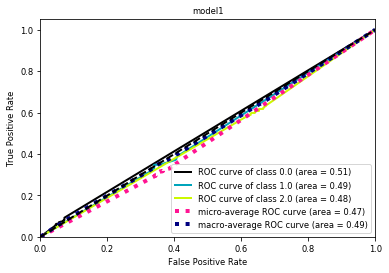

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

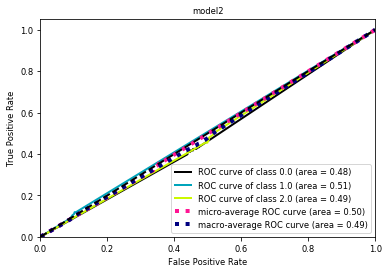

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

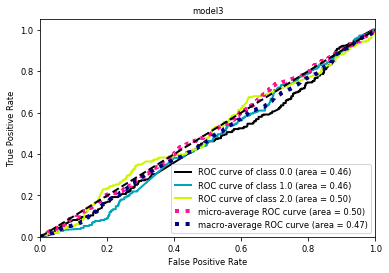

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

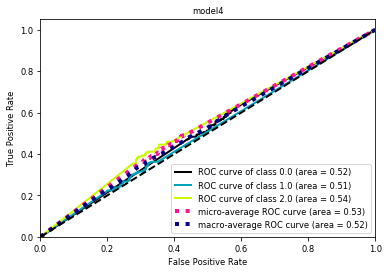

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

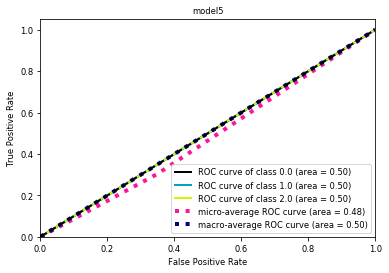

In [24]:
result_dict = {}
accuracy_list = []
auc_score_list = []
recall_list = []
precision_list = []

for i in range(5):
#     gs = output_3['GridObject'].iloc[i]
#     best = gs.best_estimator_
    best = models[i]
    feats = feats_com[i]
    X,y = get_data(df, feats, 'vb100_vf2_volatility_VWAP_200')
#   print('AUC_{}'.format(i+1), AUC(y[-818:],best.predict_proba(X[-818:])))
    y_true = y[2758:]
    y_probas = best.predict_proba(X[2758:])
    best.fit(X[:2758],y[:2758],sample_weight = df['sample_weights_vb100_vf2_volatility_VWAP_200'][:2758])
    plot_AUC(y[2758:],best.predict_proba(X[2758:]),'model{}'.format(i+1))
#     print(y_probas.shape)
    recall_list.append(recall(y_true,y_probas))
    precision_list.append(precision(y_true,y_probas))
    accuracy_list.append(accuracy(y_true,y_probas))
    auc_score_list.append(AUC(y_true,y_probas))
#     print(best.predict_proba(X[4151:]))
result_dict['AUC'] = auc_score_list
result_dict['accuracy'] = accuracy_list
result_dict['recall'] = recall_list
result_dict['precision'] = precision_list 
#   gs.cv_results_['mean_train_AUC']

In [28]:
pd.DataFrame.from_dict(result_dict)

,AUC,accuracy,recall,precision
0,0.508067,0.541304,0.444167,0.311367
1,0.498441,0.696377,0.000000,0.303623
2,0.498001,0.650725,0.121793,0.297378
3,0.500000,0.499275,0.500000,0.303623
4,0.504729,0.503623,0.505878,0.305308


### dataframe

In [38]:
# gs = output_3['GridObject'].iloc[0]
# best = gs.best_estimator_
best = models[0]
feats = feats_com[0]
X,y = get_data(df, feats, 'vb100_vf2_volatility_VWAP_200')
best.fit(X[:2758],y[:2758],sample_weight = df['sample_weights_vb100_vf2_volatility_VWAP_200'][:2758])
prediction_df = pd.DataFrame(best.predict_proba(X[2758:]),columns = ['idel_1','buy_1','sell_1']).reset_index()

for i in range(1,5):
#     gs = output_3['GridObject'].iloc[i]
#     best = gs.best_estimator_
    best = models[i]
    feats = feats_com[i]
    X,y = get_data(df, feats, 'vb100_vf2_volatility_VWAP_200')
    best.fit(X[:2758],y[:2758],sample_weight = df['sample_weights_vb100_vf2_volatility_VWAP_200'][:2758])
    predictions = pd.DataFrame(best.predict_proba(X[2758:]),
                                 columns = ['idel_{}'.format(i+1),'buy_{}'.format(i+1),'sell_{}'.format(i+1)])
    prediction_df = pd.merge(prediction_df,predictions,left_index=True,right_index= True)
    
true = pd.DataFrame(y[2758:],columns = ['true_value'])
prediction_df['true_value'] = true['true_value'] #idle
# prediction_df/

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

In [39]:
prediction_df.to_pickle('prediction_df_1.pkl')

# Plus Market features

In [40]:
## Model conbinations
from xgboost import plot_importance
market_feats = items['all_feats'][:189]
for i in range(5):
#     gs = output_3['GridObject'].iloc[i]
#     model = gs.best_estimator_
#     feats = feats_com[i]
    model = models[i]
    X,y = get_data(df,market_feats,'vb100_vf2_volatility_VWAP_200')
    model.fit(X[2758:], y[2758:],sample_weight = df['sample_weights_vb100_vf2_volatility_VWAP_200'][:2758])
    features_name = list(df[market_feats].columns.values)
    feature_importance = list(zip(features_name, model.feature_importances_))
    data = pd.DataFrame(feature_importance,columns=['feature','importance'])
    data.to_csv('./Target_One/market_importance_model{}.csv'.format(i+1))


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

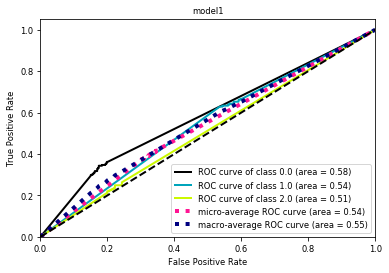

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

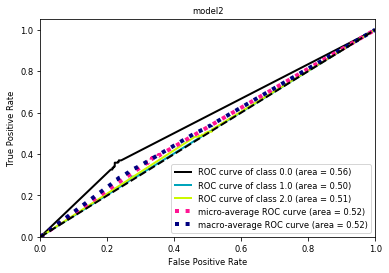

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

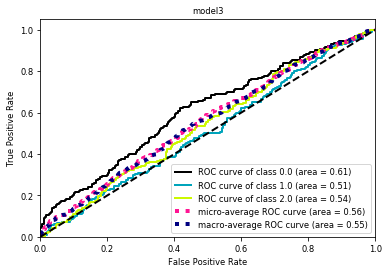

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

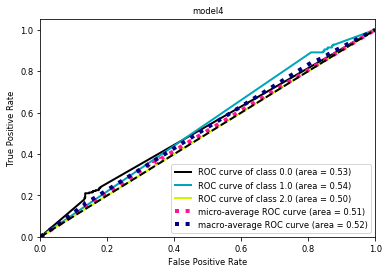

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

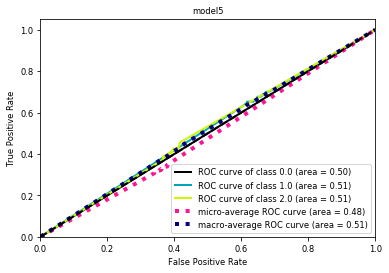

In [41]:
## pick important market features
result_dict = {}
accuracy_list = []
auc_score_list = []
recall_list = []
precision_list = []
for i in range(5):
    gs = output_3['GridObject'].iloc[i]
    model = gs.best_estimator_
    market_feats = pd.read_csv('./Target_One/market_importance_model{}.csv'.format(i+1))['feature'].tolist()[:20]
    feats = feats_com[i] + market_feats
    X,y = get_data(df, feats, 'vb100_vf2_volatility_VWAP_200')
    model.fit(X[:2758],y[:2758],sample_weight = df['sample_weights_vb100_vf2_volatility_VWAP_200'][:2758])
    y_true = y[2758:]
    y_probas = model.predict_proba(X[2758:])
    y_predict = model.predict(X[2758:])
    
    plot_AUC(y_true,y_probas,'model{}'.format(i+1))
    accuracy_list.append(accuracy(y_true,y_probas))
    auc_score_list.append(AUC(y_true,y_probas))
    recall_list.append(recall(y_true,y_probas))
    precision_list.append(precision(y_true,y_probas))
    
    if i == 0:
        prediction_df = pd.DataFrame(y_probas,
                                     columns = ['idel_{}'.format(i+1),'buy_{}'.format(i+1),'sell_{}'.format(i+1)])
    else:
        predictions =  pd.DataFrame(y_probas,
                                     columns = ['idel_{}'.format(i+1),'buy_{}'.format(i+1),'sell_{}'.format(i+1)])
        prediction_df = pd.merge(prediction_df,predictions,left_index=True,right_index= True)

true = pd.DataFrame(y[2758:],columns = ['true_value'])
prediction_df['true_value'] = true['true_value'] #idle
prediction_df.to_pickle('prediction_df_market1.pkl')
result_dict['AUC'] = auc_score_list
result_dict['accuracy'] = accuracy_list
result_dict['recall'] = recall_list
result_dict['precision'] = precision_list

In [42]:
pd.DataFrame.from_dict(result_dict)

,AUC,accuracy,recall,precision
0,0.526161,0.565942,0.429107,0.317006
1,0.504590,0.556522,0.379722,0.306643
2,0.525522,0.625362,0.197961,0.317975
3,0.520134,0.547826,0.445238,0.313160
4,0.513367,0.510870,0.517601,0.308190


In [45]:
market_feats = items['all_feats'][:189]
for i in range(5):
#     gs = output_3['GridObject'].iloc[i]
    model = models[i]
    feats = feats_com[i] + market_feats
    X,y = get_data(df, feats, 'vb100_vf2_volatility_VWAP_200')
    model.fit(X[:2758],y[:2758],sample_weight = df['sample_weights_vb100_vf2_volatility_VWAP_200'][:2758])
    y_true = y[2758:]
    y_probas = model.predict_proba(X[2758:])
    y_predict = model.predict(X[2758:])
    
#     plot_AUC(y_true,y_probas,'model{}'.format(i+1))
#     accuracy_list.append(accuracy_score(y_true,y_predict))
#     auc_score_list.append(AUC(y_true,y_probas))
    
    if i == 0:
        prediction_df = pd.DataFrame(y_probas,
                                     columns = ['idel_{}'.format(i+1),'buy_{}'.format(i+1),'sell_{}'.format(i+1)])
    else:
        predictions =  pd.DataFrame(y_probas,
                                     columns = ['idel_{}'.format(i+1),'buy_{}'.format(i+1),'sell_{}'.format(i+1)])
        prediction_df = pd.merge(prediction_df,predictions,left_index=True,right_index= True)

true = pd.DataFrame(y[2758:],columns = ['true_value'])
prediction_df['true_value'] = true['true_value'] #idle
prediction_df.to_pickle('prediction_df_all1.pkl')

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

In [57]:
final = {}
# market_feats1 = pd.read_csv('./Target_One/market_importance_model{}.csv'.format(1))['feature'].tolist()[:20]
# market_feats2 = pd.read_csv('./Target_Two/market_importance_model{}.csv'.format(4))['feature'].tolist()[:20]
# market_feats3 = pd.read_csv('./Target_Three/market_importance_model{}.csv'.format(2))['feature'].tolist()[:20]

final['Target_1'] = [pol_sub + source]
final['Target_2'] = [pol_sub+source+title+Doc2Vec+tfidf+gram+pos]
final['Target_3'] = [tfidf+pol_sub]
# Target_1 : source+Doc2Vec+pos
# Target_2 : source+pos+tfidf+Doc2Vec+gram
# Target_3 : source+tfidf+pos
pd.DataFrame(final)

,Target_1,Target_2,Target_3
0,"[polarity, subjectivity, source_bow_f1, source...","[polarity, subjectivity, source_bow_f1, source...","[tfidf_f1, tfidf_f2, tfidf_f3, tfidf_f4, tfidf..."


In [41]:
# np.save('nlp_feats.npy', final) 

In [47]:
# pd.DataFrame(final)

,Target_1,Target_2,Target_3
0,"[source_bow_f1, source_bow_f2, source_bow_f3, ...","[source_bow_f1, source_bow_f2, source_bow_f3, ...","[source_bow_f1, source_bow_f2, source_bow_f3, ..."


In [58]:
nlp_feats = pd.DataFrame.from_dict(final,orient='index')
nlp_feats.to_pickle('nlp_feats.pkl')

In [59]:
nlp_feats

,0
Target_1,"[polarity, subjectivity, source_bow_f1, source..."
Target_2,"[polarity, subjectivity, source_bow_f1, source..."
Target_3,"[tfidf_f1, tfidf_f2, tfidf_f3, tfidf_f4, tfidf..."


In [10]:
feats_com = [pol_sub,pol_sub+source,pol_sub+source+title,
            pol_sub+source+title+Doc2Vec+tfidf,
            pol_sub+source+title+Doc2Vec+tfidf+gram+pos]

from sklearn.dummy import DummyClassifier




stra = "stratified"
feats = feats_com[3]
X,y = get_data(df, feats, 'vb100_vf2_volatility_VWAP_200')
clf = DummyClassifier(strategy=stra, random_state=0)
clf = clf.fit(X[:2758], y[:2758])
y_probas = clf.predict_proba(X[2758:])
predictions1 =  pd.DataFrame(y_probas,
                            columns = 
                            ['idel_nlp','buy_nlp','sell_nlp'])
true = pd.DataFrame(y[2758:],columns = ['true_value'])
predictions1['true_value'] = true['true_value']
predictions1.to_pickle('./Dummy/prediction_dummy_nlp1.pkl')


feats = feats_com[1] + items['all_feats'][:189]
X,y = get_data(df, feats, 'vb100_vf2_volatility_VWAP_200')
clf = DummyClassifier(strategy=stra, random_state=0)
clf = clf.fit(X[:2758], y[:2758])
y_probas = clf.predict_proba(X[2758:])
predictions2 =  pd.DataFrame(y_probas,
                            columns = 
                            ['idel_all','buy_all','sell_all'])
true = pd.DataFrame(y[2758:],columns = ['true_value'])
predictions2['true_value'] = true['true_value']
predictions2.to_pickle('./Dummy/prediction_dummy_all1.pkl')

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pandas/core/frame.py:3113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu